# <span style='color:#F76241'>|</span> Recommender Systems </b>
*System Development for Marketing*
*by Stine Svaerke*

Recommender systems have seen an immense growth in popularity in recent years as the rapid expansion of the internet continues (Lü et al., 2012). Through the creation of meaningful recommendations to users, organisations have unlocked new opportunities and challenges. Recommender systems apply several different sources of information to provide users with recommendations. These sources of information include demographic information, preferences, and social behaviour (Núnez-Valdéz et al., 2012). Furthermore, recommendation systems are built on different techniques such as Collaborative Filtering, Content-based, and Hybrid Recommendation (Kaur & Bathla, 2019). The most widely applied technique of Collaborative Filtering, provides recommendations based on past ratings of an item by similar users. Specifically, collaborative filtering collects information regarding users' past behaviour and opinions, to correlate with a new user and determine similarity. Collaborative filtering can be categorised into three categorise: Model-Based, Memory-Based, and Hybrid-Based. <br>

The aim of this notebook is to investigate the application of collaborative filtering to build a recommender system. In order to gain business applications from the investigation, the following business question has been devised. <br>

**<span style='color:#F76241'>Main Research question:</span>** </br>
 *Which method of collaborative filtering should Jester use to best recommend jokes to users? </br>*



</br>**<span style='color:#F76241'>Sub-Research questions:</span>** </br>
1. Which evaluation metrics would be most appropriate to evaluate the recommender systems?
2. How does KNN and SVD recommender systems compare in terms of their prediction accuracy?
3. How do KNN and SVD recommender systems differ in terms of their generalisability?

Sub-questions one and two will be investigated in section 1 and 2 of this notebook. Additionally, sub-question three will be investigated in section 3, in which the resulting KNN and SVD recommender systems from sections 1 and 2 will be applied to a different dataset (Netflix) to test for generalisability.


In [58]:
#Importing the neccessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#For K-Nearest Neighbour Recommender System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#For Singular Decompostion Value Recommender System
import sklearn
from scipy.sparse.linalg import svds

In [59]:
#Importing the Jester Dataset. Only the jester_ratings file is imported as the jester_items does not have additional information that is important.  
df_Jester = pd.read_csv('/Users/stinesvaerke/Desktop/jester_ratings.csv', encoding='ISO-8859-1', delimiter=',', usecols=['userId', 'jokeId', 'rating'])

### <b>1<span style='color:#F76241'>|</span> Exploratory Data Analysis of the Jester Dataset<br>

To gain an understanding of the dataset and the variables within the data set, an exploratory data analysis will be conducted. The exploratory data analysis of the dataset is limited as it is mainly to understand the variables which the dataset contains and preprocessing of the data. 

In [60]:
#Printing the headers of the dataset
df_Jester.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [61]:
#Checking the data types 
df_Jester.dtypes

userId      int64
jokeId      int64
rating    float64
dtype: object

In [62]:
# Checking the dimensions of the data
print("Data shape: ", df_Jester.shape)

Data shape:  (1761439, 3)


In [63]:
df_Jester.describe()

,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


<function matplotlib.pyplot.show(close=None, block=None)>

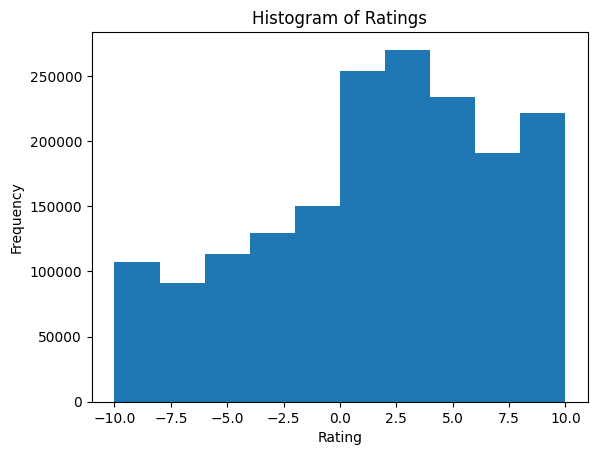

In [64]:
#Visualising the distribution of ratings
plt.hist(data=df_Jester, x="rating")
plt.title("Histogram of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show

The historgram plot of the ratings, show that they are slightly left-skewed. This means that the ratings are mainly concentrated on the right-side, in the positive ratings. 

### <b>2<span style='color:#F76241'>|</span> K-Nearest Neighbour Modelling 
K-Nearest Neighbour (KNN) is an non-parametric alogrithm that identifies users with similar preferences in the past to recommend similar items in the future. The alogirthm finds the nearest K-neighbours in a space to recommend similar items to a user. When applying the KNN algorithm for building a recommender system, there are several implicit assumptions that must be considered first: <br>

1. Neighbourhood: KNN assumes that similar users or items have similar ratings or preferences. 
2. Sparcity: Insufficient information in the form of sparse datasets may affect KNN to accurately estimate the preferences of users.
3. Choice of K: Selecting the number of nearest neighbours can affect the accuracy and coverage of the recommendations.
4. Distance: Choice of distance metric can impact the performance of the algorithm, therefore different distance metrics may be appropriate for different types of data. 
5. Curse of dimensionality: High numberof features or dimensions may lead the algorithm to struggle to find meaningful neighbors. 

In [65]:
# pivot ratings into joke features, in which each row represents a user and each column represents a joke. 
df_joke_matrix = df_Jester.pivot(
index='userId',
columns='jokeId',
values='rating'
).fillna(0)

<span style='color:#F76241'>|</span>The pivoted Jester matrix is very large and empty, as users have only mainly only rated a small subset of the total jokes. Therefore, the matrix should be converted to a sparse matrix representation for memory efficiency and computational costs reasons. A sparse matrix only store the non-zero values and their indices. In order to do this, the csr_matrix function will be applied. 

In [66]:
#converting dense matrix to scipy sparse matrix
ratingmatrix = csr_matrix(df_joke_matrix.values)

In [67]:
#Splitting the sparse matrix into training, validation, test sets. 
#This will allow for the KNN model to be train, validated, and tested with different subsets of the data. 
train_matrix, test_matrix = train_test_split(ratingmatrix, test_size=0.2)
test_matrix, validation_matrix = train_test_split(test_matrix, test_size=0.5)

In [68]:
#Defining the KNN model
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model.fit(ratingmatrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### 2.1<span style='color:#F76241'>|</span> Hyperparameter Tuning <br>
Hyperparameter tuning is the process of finding the optimal parameters for the model. Hyperparameters are parameters of the model that are set before training and cannot be learned from the data. There are several hyperparameters that must be tuned for a KNN recommender system including distance metric, K, and similarlity metric. Tuning these hyperparameters will result in the best combination of hyperparameters that optimise the performance of the recommender system. 

Hyperparameter tuning will address the implicit assumptions mentioned in the introducution section to the KNN modeling. For example, the choice of K will have an affect on the coverage and speed of the recommendations, whereas the distance metric can impact the accuracy of the recommendations. Furthermore, the hyperparameters are important for the generalisability of the system. Tuning the hyperparameters can ensure that the system can be generalised well to new datasets. 

Several hyperparameters are considered when tuning the KNN recommender system. Firstly, the distance metric is used to calculate the distance between items or users. Different distance metrics can be applied depending on the type of data or features. Secondly, The similiarity metric refers to the similarity between items or users. Lastly, the number of nearest neighbours (K) refers to the number of nearest neighbours that the system considers when making a recommendation. Overall, these hyperparameters directly influence the accuracy, coverage, and speed of the recommendations. 

In order to find the optimal combination of hyperparameters, several methods can be used. The most common method is the grid search or randomised search, in which a range of hyperparameters are specified and the performance of the model is evaluated for each combination of hyperparameters. However, for tuning the current system, the hyperparameter tuning is coded by hand with elements of the gridsearch function included. 

In [69]:
#Defining a function to find the optimal hyperparameters for the model
def build_knn (data=validation_matrix, nr_recommendations=5, metric='manhattan', n_neighbors=15):
    model_knn = NearestNeighbors(metric=metric, algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    model_knn.fit(train_matrix)

#predicted ratings
    test_predicted_ratings = np.zeros_like(data.toarray())
    for user_id in range(data.shape[0]):
        distances, indices = model_knn.kneighbors(data[user_id], n_neighbors=nr_recommendations)
        user_ratings = train_matrix[indices.flatten(), :].toarray()
        weights = 1 / (distances.flatten() + 1e-6)
        test_predicted_ratings[user_id] = np.sum(user_ratings * weights.reshape(-1, 1), axis=0) / np.sum(weights)

#Calculating the RMSE for the hyperparameters to be able to determine which hyperparameters are the best. 
    test_actual_ratings = data.toarray()[test_predicted_ratings > 0]
    test_predicted_ratings = np.array(test_predicted_ratings)[test_predicted_ratings > 0]
    rmse = np.sqrt(mean_squared_error(test_actual_ratings, test_predicted_ratings))
    return rmse

<span style='color:#F76241'>|</span>The defined method to find the optimal hyperparameters for the KNN recommender system as seen above is based on the following logic. The function focuses on the four arguments: the data (validation subset), the number of recommendations to make, the distance metric to use, and the number of nearest neighbours (K) to consider.

1. #Defining a function to find the optimal hyperparameters for the model:<br>
The function createst a KNN model using the specified distance metric and number of neighbours. The model is then fitted on the training data subset. 

 2. #predicted ratings:<br>
 the function predicts the ratings for the validation data using the KNN model. This is done for each user in the validation subset, where the function finds the K nearest neighbours from the training data and uses their ratings to make recommendations for that user. The predicted ratings are calculated using a weighted average of the ratings of the nearest neighbours, where the weights are inversley proportional to the distance between theneighbours and the user being recommended for. 

3. #Calculating the RMSE for the hyperparameters to be able to determine which hyperparameters are the best.<br> 
The function calculates the root mean squared error (RMSE) between the actual ratings in the validation subset and the predicted ratings. The RMSE is an evaluation metric which measures the accuracy of the recommendations, whereby a lower value indicates better performance. 

Finally, the defined method allows for comparison of the performance of different hyperparameters through the returned RMSE. From this, the optimal combination can be choosen for the KNN recommender system. 

In [70]:
#Computing the hyperparameters for the validation dataset. 
# By looping through all possible combinations of thehyperparameters, the hyperparameter space is explored and the optimal combination
# that results in the lowest RMSE can be identified. This approach ensures that the system is able to be generalized to new data. 
# This is not a computational efficient method, however it is very thorough. The code has been run once and it took 78 minutes, therefore it
# will not be run again
rmse = build_knn()
nr_recommendations = [5,7,9]
n_neigbours = [10, 20, 50]
metric = ['minkowski','euclidean','manhattan']
parameters = []
for number in nr_recommendations:
    for par in metric: 
        for tal in n_neigbours:
            parameters.append([build_knn(data = validation_matrix, metric=par, nr_recommendations=number), par, number, tal])

KeyboardInterrupt: 

In [ ]:
# Printing the best parameters, based on the loop above. 
best_parameters = sorted(parameters, key= lambda x: x[0])[0]
print(best_parameters)

<span style='color:#F76241'>|</span> The best parameters for the model are metric: minkowski, n_neighbors: 9, nr.recommendations: 10. Now that the optimal hyperparameters have been identified, the recommender system can be defined and fitted with these hyperparameters and the test dataset.

In [71]:
#The best parameters inputed to the model and fitted to the test subset.
knn_model = NearestNeighbors(metric = 'minkowski', algorithm = 'brute', n_neighbors=9)
knn_model.fit(test_matrix)

NearestNeighbors(algorithm='brute', n_neighbors=9)

### 2.2<span style='color:#F76241'>|</span> Testing the KNN Recommender System with Optimal Hyperparameters <br>
This section applies the identified optimal hyperparameters to the model. Furthermore, the section identifies the K-nearest neighbours for a random user and provides recommeded jokes to the target user based on the preferences of the K-nearest neighbours. 

<span style='color:#F76241'>|</span> To find the K-nearest neigbors for each user in the test set using, the kneighbors() method is applied. This calculates the distance and indices of the K-nearest neighbors for each user. Furthermore, the kneighbors() method inputs the test data and returns two arrays: distances and indices. The distance array contains the distances between each user and the k-nearest neighbors, whereas the indices array includes the indices of the k-nearest neighbors in the training subset. 

In [72]:
distances, indices = knn_model.kneighbors(test_matrix)

<span style='color:#F76241'>|</span> The following code will print the K-nearest neighbours to a random user. By first identifying the indices of jokes that a random user has not yet rated and those that the random user has rated, it creates a new matrix. The matrix contains only the rows of users who have rated the same jokes as the random user and have rated at least one of the unrated jokes. The matrix is then fitted to the KNN model, which calculates the indices of the k-nearest neighbors for the random user in the original matrix. Finally, the code loops through the distances and indices arrays to print the k-nearest neighbours that have rated all the unrated jokes. This is done by checking if the neighbour has rated any of the unrated jokes and only printing the neighbour if they have not rated any of the unrated jokes. This results in the K-nearest neighbours along with their distance to the random user. 

In [73]:
#code adapted from Makwana (2020) 
# Get the indices of the jokes that a random user has not yet rated
unrated_jokes_indices = np.where(df_joke_matrix.iloc[query_index].isnull())[0]

#Get the indices of the jokes that a random user has rated
rated_jokes_indices = np.where(~np.isnan(df_joke_matrix.iloc[query_index]))[0]

# Creating a new matrix containing only the rows of users who have rated the same jokes as 
# the random user and rated at least one of the unrated jokes. 
df_joke_matrix_rated = df_joke_matrix.iloc[:, rated_jokes_indices].dropna()
df_joke_matrix_rated = df_joke_matrix.loc[(df_joke_matrix_rated[unrated_jokes_indices] == 0).all(axis=1)]

# Fitting the KNN model on the new matrix
knn_model = NearestNeighbors(metric='minkowski', algorithm='brute', n_neighbors=9)
knn_model.fit(df_joke_matrix_rated)

#Calculating indices of the k-nearest neighbours for random user in matrix
distances, indices = knn_model.kneighbors(df_joke_matrix.iloc[query_index, rated_jokes_indices].values.reshape(1, -1), n_neighbors=9)

#Printing the k-nearest neighbours
num_recommendations = 10
counter = 0
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Similarities for user {0}:\n'.format(df_joke_matrix.index[query_index]))
    elif counter >= num_recommendations:
        break
    else:
        # Get the indices of the unrated jokes for the current neighbor
        unrated_jokes_indices_neighbor = np.where(df_joke_matrix_rated.iloc[indices.flatten()[i]].isnull())[0]
        # Check if the neighbor has rated any of the unrated jokes
        if len(unrated_jokes_indices_neighbor) == len(unrated_jokes_indices):
            print('{0}: {1}, with distance of {2}:'.format(counter+1, df_joke_matrix_rated.index[indices.flatten()[i]], distances.flatten()[i]))
            counter += 1

Similarities for user 1699:

1: 30043, with distance of 30.339037278727222:
2: 13675, with distance of 30.913750920908967:
3: 25888, with distance of 31.083360243062526:
4: 28294, with distance of 31.27855413857872:
5: 7166, with distance of 31.364858743504648:
6: 23472, with distance of 31.388465540704598:
7: 62652, with distance of 31.517894885286992:
8: 57383, with distance of 31.615759820064422:


<span style='color:#F76241'>|</span> As the aim of the recommender system is to answer the business question "Which method of collaborative filtering should Jester use to best recommend jokes to users?", the system must be able to calculate recommended jokes for users. Therefore, to find the recommended jokes, an index of the random user is set. This is followed by finding the distances and indices of the k-nearest neighbours most similar to the target user. The jokes that the target user has not yet rated are identified by creating a boolean mask, in which unrated jokes have a value of 0. From this an empty list to store the recommended jokes is created. A loop of the top k-nearest neighbours and for ech user is performed. This gets the indices of the jokes that the target user has rated using a boolean mask where rated jokes have a value other than 0. The set difference between the rated jokes and the unrated jokes is calculated to get a list of jokes that the similar users have rated but the target user has not yet rated and are added to the recommended jokes list. Finally, the top 10 jokes are printed from the recommended jokes list. 

In [75]:
# Set the index of the user you want to make recommendations for
query_index = df_joke_matrix.index.get_loc(1699)

# Find the distances and indices of the closest users
distances, indices = knn_model.kneighbors(df_joke_matrix.iloc[query_index].values.reshape(1, -1), n_neighbors=9)

# Find the jokes that the target user has not yet rated (i.e., the unrated jokes)
unrated_mask = df_joke_matrix.iloc[query_index] == 0
unrated_jokes = df_joke_matrix.columns[unrated_mask]

# Find the jokes that the top 5 similar users have rated but the target user has not yet rated
recommended_jokes = []
for i in range(1, len(distances.flatten())):
    # Get the indices of the jokes that the current similar user has rated
    rated_mask = df_joke_matrix.iloc[indices.flatten()[i]] != 0
    rated_jokes = df_joke_matrix.columns[rated_mask]
    # Find the jokes that the similar user has rated but the target user has not yet rated
    recommended_jokes.extend(list(set(rated_jokes) - set(unrated_jokes)))
    # Only recommend up to 5 jokes for the user
    if len(recommended_jokes) >= 5:
        break

# Print the recommended jokes
print('Recommended jokes for user {0}:'.format(df_joke_matrix.index[query_index]))
for i, joke in enumerate(recommended_jokes[:10]):
    print('{0}: jokeID {1}'.format(i+1, joke))


Recommended jokes for user 1699:
1: jokeID 7
2: jokeID 8
3: jokeID 105
4: jokeID 13
5: jokeID 15
6: jokeID 16
7: jokeID 17
8: jokeID 18
9: jokeID 19
10: jokeID 118


### 2.3<span style='color:#F76241'>|</span> Evaluation <br>  
In order to evaluate the KNN recommender system, the root mean squared error (RMSE) is calculated. The RMSE measures the difference between the predicted ratings and the actual ratinngs. As mentioned earlier a lower RMSE indicates that the recommender system is better at predicting ratings and therefore more accurate. The RMSE for the KNN recommender system is 2.81. Whiler this value may seem relaitively high, it is important to not that the rating sclae ranges from -10 to 10. Therefore, an RMSE of 2.81 indicates that, on average, the system's predicted ratings are off by approximately 3 rating points, which is a significant difference on this cale. 

Additionally, this level of error could potentialy lead to the system recommending jokes that a user may not enjoy, as the predicted ratings may be significantly different from the user's actual ratings. Thus, additional evaluation and refining of the recommender system should be conducted to improve the accuracy and minimize the RMSE. Furthermore, collecting more data and incorporating these could help improve the system's performance over time. 

### <b>3<span style='color:#F76241'>|</span> Singular Value Decomposition <br>
Singular Value Decomposition (SVD) is a technique that applies matrix factorisation technique to build recommender systems that identifies latent features that affect the interaction between users and items inn a rating matrix. SVD decomposes the original matrix into three matrices: a user matrix, a joke matrix, and a diagonal matrix with different weights of the latent features. The user matrix represents how much each user likes each feature, the joke matrix represents how much each joke has each feature, and the diagonal matrix represents how important each feature is to the overall rating. By multiplying the three matrices, the original rating matrix can be reconstructed and predict how users would rate new jokes.  

SVD is beneficial as it handles the spasity of rating matrices and can make accurate predictions even when there are missing ratings. However, choosing an appropriate rank can be challenging, as too low of a rank may result in poor prediction accuracy, while too high of a rank may cause overfitting and increase computational complexitiy. 

### 3.1<span style='color:#F76241'>|</span> Hyperparameter Tuning <br>
Similar to hyperparameter tuning in the K-nearest neighbour model, tuning is important for constructing a high-performing SVD-based recommender system. The hyperparameters that can affect the performance of the SVD, therefore choosing appropriate hyperparameters is crucial. The hyperparameters which could influence the performance include the rank, the learning rate, the regularisation parameter, and the number of iterations. <br>

1. The Rank: Number of latent factors used in the decomposition of the rating matrix. This represents the number of dimensions that capture the interactions between the users and items. 
2. The Learning Rate: Determines the step size for updating the user and joke matrices in each iteration of the optimization algorithm. 
3. The Regularisation Parameter: Controls the ability of the system to generalise to new data.
4. The Number of Iterations: Maximum number of times that the optimisation algorithm iterates over the training data to find the optimal combination. 

Overall, hyperparameter tuning aims to optimise the system's performance. By choosing the appropriate hyperparameters, the system's accuracy and generaliability can be improved.

In [ ]:
#Define function for SVD. (r=number of latent factors to use in decomposition)
def build_svd(data,r=5):
    #Computing SVD components on the training rating matrix to reduce dimensionality.
    u, s, Vt = svds(masked_dataset_csr.toarray(), k=r)

    #Constructing diagonal matrix from the singular values in sigma. 
    sigma_diag_matrix = np.diag(s)

    #Computing the predicted ratings for all users and jokes. 
    X_pred = np.dot(np.dot(u, sigma_diag_matrix), Vt)
    return X_pred

<span style='color:#F76241'>|</span> After having defined a function for computing the singular value decomposition, the hyperparameter tuning can take place. The code below conducts the hyperparameter tuning by defining a list of values for the hyperparameter including the variable r which controls the number of latent factors used by the SVD model. Furthermore, this is done by creating a training subset of the original Jester dataset into a masked dataset and a sample dataset. The masked dataset is used to train the SVD model, by returning predicted ratings based on the SVD model. The predicted ratings are then compared to the actual ratings in the sample dataset using the RMSE metric. 

In [ ]:
r_list = [2,5,10] 
parameters = []
for r in r_list:
    #Creating dataset and sample
    masked_dataset, actual_sampledata = train_test_split(df_Jester, test_size=0.15)

    masked_dataset_csr = csr_matrix(masked_dataset.pivot(index='userId', columns='jokeId', values='rating').fillna(0).values)
    actual_sampledata_csr = csr_matrix(actual_sampledata.pivot(index='userId', columns='jokeId', values='rating').fillna(0).values)

    prediction = build_svd(masked_dataset_csr.toarray(),r=r)

    prediction = prediction[actual_sampledata_csr.toarray().nonzero()].flatten()
    actual_values = actual_sampledata_csr.toarray()[actual_sampledata_csr.toarray().nonzero()].flatten() 
    
    rmse = np.sqrt(mean_squared_error(prediction, actual_values))
    parameters.append([r, rmse])

In [ ]:
# Printing the best parameters based on the hyperparameter tuning above. 
best_parameters = sorted(parameters, key= lambda x: x[0])[0]
print(best_parameters)

[2, 5.604705952979521]


<span style='color:#F76241'>|</span> As can be seen the optimal number of iterations for the SVD model is 2, with the lowest RMSE of 5.60. <br>

In order to test the system with the optimal hyperparameters, the original dataset is once again split into a training and test set and converted into compressed sparse row matrices. The SVD model using the best hyperparameters is defined (r=2) to get the predicted ratings for all users and jokes. Finally, a random user is selected and their predicted ratings for all jokes are retreived. The ratings are sorted in descending order, in which the top 5 rated jokes are slected to finally recommend 5 jokes to the selected user. 

In [ ]:
#Splitting the dataset into a training and test subset. 
masked_dataset, actual_sampledata = train_test_split(df_Jester, test_size=0.15)

masked_dataset_csr = csr_matrix(masked_dataset.pivot(index='userId', columns='jokeId', values='rating').fillna(0).values)
actual_sampledata_csr = csr_matrix(actual_sampledata.pivot(index='userId', columns='jokeId', values='rating').fillna(0).values)

#Getting predictions with best parameters
prediction = build_svd(masked_dataset_csr.toarray(), r=2)
prediction = pd.DataFrame(prediction)

# Selecting user
query_index = 8574

#Creating selected user rating list 
user_prediction = prediction.loc[query_index].sort_values(ascending=False) 
print(user_prediction.head(5))


78     2.124583
42     2.043844
118    1.950721
103    1.941552
94     1.926793
Name: 8574, dtype: float64


### 2.3<span style='color:#F76241'>|</span> Evaluation <br>  
In order to evaluate the SVD recommender system, the root mean squared error metric is applied. The SVD recommender system produced an RMSE of 5.60, which is considered very high, as the rating score ranges between -10 and 10. This means that the recommender system is off by approximately 6 rating points, which could lead users to be recommended jokes that they would not enjoy. Therefore the SVD recommender system need further improvement to accurately predict the preferences of users. Examples of further improvements could be to look into the data quality or need for additional features in the model. Moreover, additional evaluation metrics could be calculated to verify the poor performance of the SVD recommender system such as precision and recall (measure how well the system retrieves relevant information).

### <b>3<span style='color:#F76241'>|</span> Applying the KNN and SVD Recommender Systems to a NetfliX Dataset<br>
To understand the generalisability of the KNN and SVD recommender systems constructed above, a Netflix dataset will be applied. This will allow the following sub-question to be investigated <br>

*"How do KNN and SVD recommender systems differ in terms of their generalisability?"*

In [ ]:
#Importing the .tar files of the Netflix dataset - Code by Viktor
# The dataset files have been preliminarly investigated in excel and textEdit and it has been determined that only the training_set is
# neccessary to import. 

# Importing all the files from the folder in the .rar file
Train_data = []

directory_path = '/Users/stinesvaerke/Desktop/training_set'

# Initialize an empty list to store each dataframe from each file
df_list = []

# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    # Check that the file is a text file
    if file_name.endswith('.txt'):
        # Read in the file as a dataframe
        df = pd.read_csv(os.path.join(directory_path, file_name), header=None, names=['CustomerID', 'Rating', 'Date'])
        # Get the Movie ID from the file name
        movie_id = int(file_name.split('_')[1].split('.')[0])
        # Add the Movie ID as a column to the dataframe
        df['Movie ID'] = movie_id
        # Add the dataframe to the list
        df_list.append(df)

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

# Print the resulting dataframe
print(df.head())

  CustomerID  Rating        Date  Movie ID
0       373:     NaN         NaN       373
1     643460     4.0  2005-01-26       373
2     349399     5.0  2002-11-06       373
3    1315469     2.0  2005-08-15       373
4    1022903     3.0  2002-11-27       373


### <b>3.1<span style='color:#F76241'>|</span> Exploratory Data Analysis <br>

To gain an understanding of the data set and the variables within the data set, an exploratory data analysis will be conducted. 

In [ ]:
#Checking the data types 
df.dtypes

CustomerID     object
Rating        float64
Date           object
Movie ID        int64
dtype: object

In [ ]:
#Checking the headers of the datasets
print(df.head())

  CustomerID  Rating        Date  Movie ID
0       373:     NaN         NaN       373
1     643460     4.0  2005-01-26       373
2     349399     5.0  2002-11-06       373
3    1315469     2.0  2005-08-15       373
4    1022903     3.0  2002-11-27       373


<span style='color:#F76241'>|</span> The "Date" column of the df dataset is also not relevant for this investigation and will therefore be dropped.  

In [ ]:
#Dropping the date column in df dataframe and renaming the dataframe df_netflix
df_netflix = df.drop(['Date'], axis=1)

In [ ]:
#Checking the column names of the new dataframe.
df_netflix.head()

,CustomerID,Rating,Movie ID
0,373:,NaN,373
1,643460,4.0,373
2,349399,5.0,373
3,1315469,2.0,373
4,1022903,3.0,373


In [ ]:
# Checking the dimensions of the data
print("Data shape: ", df_netflix.shape)

Data shape:  (80590486, 3)


In [ ]:
df_netflix['Movie ID'].value_counts()

11040    101780
6859     101501
2391     101189
12870    101142
4472     101119
          ...  
4806         14
6256         11
11344        11
11148         6
13755         4
Name: Movie ID, Length: 17619, dtype: int64

In [ ]:
df_netflix['CustomerID'].value_counts()

305344     17509
387418     17285
2439493    16414
1664010    15662
2118461    14680
           ...  
14617:         1
14171:         1
4362:          1
12500:         1
7405:          1
Name: CustomerID, Length: 496460, dtype: int64

In [ ]:
#Due to the size of the original dataset and the high computational cost of running it, a sample will be taken. 
# Get a random sample of 2000 unique (CustomerID, MovieID) pairs
customer_movie_pairs = df_netflix[['CustomerID', 'Movie ID']].drop_duplicates()
sampled_pairs = customer_movie_pairs.sample(n=2000)

# Get the rows in the original dataframe that match the sampled (CustomerID, MovieID) pairs
df_sample = df.merge(sampled_pairs, on=['CustomerID', 'Movie ID'])

# Display the resulting sampled dataframe
print(df_sample)

     CustomerID  Rating        Date  Movie ID
0       1510950     4.0  2005-01-19     12011
1        851852     3.0  2005-07-14      8049
2        246434     2.0  2002-12-06     12763
3       1730716     2.0  2005-04-13      5237
4       1806684     2.0  2003-09-17      5237
...         ...     ...         ...       ...
1995    1862374     5.0  2005-02-01     12785
1996     898195     4.0  2003-08-10     12975
1997       5727     4.0  2005-05-07      3893
1998     984323     2.0  2004-01-23      8078
1999    2390188     5.0  2004-12-12     15773

[2000 rows x 4 columns]


In [ ]:
#Rechecking columns of the sampled dataset 
df_sample.head()

,CustomerID,Rating,Date,Movie ID
0,1510950,4.0,2005-01-19,12011
1,851852,3.0,2005-07-14,8049
2,246434,2.0,2002-12-06,12763
3,1730716,2.0,2005-04-13,5237
4,1806684,2.0,2003-09-17,5237


### <b>3.2<span style='color:#F76241'>|</span> K-Nearest Neighbour Modelling for Netflix

In [ ]:
# pivot ratings into joke features, in which each row represents a user and each column represents a joke. 
df_movie_matrix = df_sample.pivot(index='CustomerID', columns='Movie ID', values='Rating').fillna(0)

In [ ]:
#converting dataframe of movie pivot matrix to scipy sparse matrix
ratingmatrix_netflix = csr_matrix(df_movie_matrix.values)

In [ ]:
#Splitting the sparse matrix into training, validation, test sets. 
#This will allow for the KNN model to be train, validated, and tested with different subsets of the data. 
train_matrix_netflix, test_matrix_netflix = train_test_split(ratingmatrix_netflix, test_size=0.2)
test_matrix_netflix, validation_matrix_netflix = train_test_split(test_matrix_netflix, test_size=0.5)

In [ ]:
#Defining the KNN model
knn_model_netflix = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model_netflix.fit(ratingmatrix_netflix)

NearestNeighbors(algorithm='brute', metric='cosine')

### <b>3.2.1<span style='color:#F76241'>|</span> Hyperparameter Tuning <br>

In [ ]:
#Defining a function to find the optimal hyperparameters for the model
def build_knn (data=validation_matrix_netflix, nr_recommendations=5, metric='manhattan', n_neighbors=15):
    knn_model_netflix = NearestNeighbors(metric=metric, algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    knn_model_netflix.fit(train_matrix_netflix)

#predicted ratings
    test_predicted_ratings = np.zeros_like(data.toarray())
    for user_id in range(data.shape[0]):
        distances, indices = knn_model_netflix.kneighbors(data[user_id], n_neighbors=nr_recommendations)
        user_ratings = train_matrix_netflix[indices.flatten(), :].toarray()
        weights = 1 / (distances.flatten() + 1e-6)
        test_predicted_ratings[user_id] = np.sum(user_ratings * weights.reshape(-1, 1), axis=0) / np.sum(weights)

#Calculating the RMSE for the hyperparameters to be able to determine which hyperparameters are the best. 
    test_actual_ratings = data.toarray()[test_predicted_ratings > 0]
    test_predicted_ratings = np.array(test_predicted_ratings)[test_predicted_ratings > 0]
    rmse = np.sqrt(mean_squared_error(test_actual_ratings, test_predicted_ratings))
    return rmse

In [ ]:
#Computing the hyperparameters for the validation dataset. 
# By looping through all possible combinations of thehyperparameters, the hyperparameter space is explored and the optimal combination
# that results in the lowest RMSE can be identified. This approach ensures that the system is able to be generalized to new data. 
# This is not a computational inexpensive method, however it is very thorough.
rmse = build_knn()
nr_recommendations = [5,7,9]
n_neigbours = [10, 20, 50]
metric = ['minkowski','euclidean','manhattan']
parameters = []
for number in nr_recommendations:
    for par in metric: 
        for tal in n_neigbours:
            parameters.append([build_knn(data = validation_matrix_netflix, metric=par, nr_recommendations=number), par, number, tal])

In [ ]:
# Printing the best parameters, based on the loop above. 
best_parameters = sorted(parameters, key= lambda x: x[0])[0]
print(best_parameters)

[0.40372243829381027, 'manhattan', 9, 10]


<span style='color:#F76241'>|</span> The best parameters for the model are metric: manhattan, n_neighbors: 9, nr.recommendations: 10. This is due to the lowest RMSE of 0.40

In [ ]:
#The best parameters inputed to the model and fitted to the test subset.
knn_model = NearestNeighbors(metric = 'manhattan', algorithm = 'brute', n_neighbors=9)
knn_model.fit(test_matrix_netflix)

NearestNeighbors(algorithm='brute', metric='manhattan', n_neighbors=9)

### 3.3<span style='color:#F76241'>|</span> Testing the KNN Recommender System with Optimal Hyperparameters <br>

In [ ]:
#code adapted from Makwana(2020) 
# Selecting random user
query_index = np.random.choice(df_movie_matrix.shape[0])

#Finding movies that target user has not yet rated
unrated_movie_indices = np.where(df_movie_matrix.iloc[query_index].isnull())[0]
urated_movie_indices = np.where(~np.isnan(df_movie_matrix.iloc[query_index]))[0]

#Finding movies that target user has rated
df_movie_matrix_rated = df_movie_matrix.iloc[:, rated_movie_indices].dropna()
df_movie_matrix_rated = df_movie_matrix.loc[(df_movie_matrix_rated[unrated_movie_indices] == 0).all(axis=1)]

#Defining and fitting model with the optimal hyperparameters
knn_model = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=9)
knn_model.fit(df_movie_matrix_rated)

#Calculating indices of the k-nearest neighbours for random user in matrix
distances, indices = knn_model.kneighbors(df_movie_matrix.iloc[query_index, rated_movie_indices].values.reshape(1, -1), n_neighbors=9)

#Printing the k-nearest neighbours
num_recommendations = 10
counter = 0
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Similarities for user {0}:\n'.format(df_movie_matrix.index[query_index]))
    elif counter >= num_recommendations:
        break
    else:
        unrated_movie_indices_neighbor = np.where(df_movie_matrix_rated.iloc[indices.flatten()[i]].isnull())[0]
        if len(unrated_movie_indices_neighbor) == len(unrated_movie_indices):
            print('{0}: {1}, with distance of {2}:'.format(counter+1, df_movie_matrix_rated.index[indices.flatten()[i]], distances.flatten()[i]))
            counter += 1


Similarities for user 50259:

1: 579549, with distance of 1.0:
2: 1217471, with distance of 5.0:
3: 1042795, with distance of 5.0:
4: 1163698, with distance of 5.0:
5: 1099977, with distance of 5.0:
6: 1188639, with distance of 5.0:
7: 1217641, with distance of 5.0:
8: 1081239, with distance of 5.0:


### <b>4<span style='color:#F76241'>|</span> Singular Value Decomposition Modelling for Netflix <br>

In [ ]:
#Define function for SVD. (r=number of latent factors to use in decomposition)
def build_svd(data,r=5):
    #Computing SVD components on the training rating matrix to reduce dimensionality.
    u, s, Vt = svds(masked_dataset_csr.toarray(), k=r)

    #Constructing diagonal matrix from the singular values in sigma. 
    sigma_diag_matrix = np.diag(s)

    #Computing the predicted ratings for all users and jokes. 
    X_pred_netflix = np.dot(np.dot(u, sigma_diag_matrix), Vt)
    return X_pred_netflix

In [ ]:
#Computing hyperparameter tuning for SVD on the Netflix sample dataset
r_list = [2,5,10] 
parameters = []
for r in r_list:
    #Creating dataset and sample
    masked_dataset, actual_sampledata = train_test_split(df_sample, test_size=0.15)

    masked_dataset_csr = csr_matrix(masked_dataset.pivot(index='CustomerID', columns='Movie ID', values='Rating').fillna(0).values)
    actual_sampledata_csr = csr_matrix(actual_sampledata.pivot(index='CustomerID', columns='Movie ID', values='Rating').fillna(0).values)

    prediction = build_svd(masked_dataset_csr.toarray(),r=r)

    prediction = prediction[actual_sampledata_csr.toarray().nonzero()].flatten()
    actual_values = actual_sampledata_csr.toarray()[actual_sampledata_csr.toarray().nonzero()].flatten() 
    
    rmse = np.sqrt(mean_squared_error(prediction, actual_values))
    parameters.append([r, rmse])

In [ ]:
# Printing the best parameters based on the hyperparameter tuning above. 
best_parameters = sorted(parameters, key= lambda x: x[0])[0]
print(best_parameters)

[2, 3.6873658167676644]


<span style='color:#F76241'>|</span> As can be seen the optimal number of iterations for the SVD model is 2, with the lowest RMSE of 3.59. This is a relatively high RMSE as it suggests that the recommender system is off by approximately 4 rating scores. <br>

In [ ]:
#Splitting the dataset into a training and test subset. 
masked_dataset, actual_sampledata = train_test_split(df_sample, test_size=0.15)

masked_dataset_csr = csr_matrix(masked_dataset.pivot(index='CustomerID', columns='Movie ID', values='Rating').fillna(0).values)
actual_sampledata_csr = csr_matrix(actual_sampledata.pivot(index='CustomerID', columns='Movie ID', values='Rating').fillna(0).values)

#Getting predictions with best parameters
prediction = build_svd(masked_dataset_csr.toarray(), r=2)
prediction = pd.DataFrame(prediction)

#Creating selected user rating list 
user_prediction = prediction.loc[query_index].sort_values(ascending=False) 
print("Top Recommended Movies for Random User:", user_prediction.head(5))

Top Recommended Movies for Random User: 1055    2.529198e-17
627     6.876380e-32
74      1.844927e-33
1109    1.609854e-33
613     1.528334e-33
Name: 529, dtype: float64


### 5<span style='color:#F76241'>|</span> Conclusion <br>

The aim of this notebook has been to invesitgate the application of collaborative filtering to build recommender systems. Two different methods have been constructed, a K-Nearest Neighbor and a Singular Value Decomposition. Both recommender systems have been hyperparameter tuned to identify the best parameters for the systems. Once, the best parameters were identified recommendations for a random user were calculated. Lastly, the models were evaluated using the RMSE as this evaluation metric provided the most accesible interprebaility of performance. Furthermore, both the KNN and SVD recommender systems were applied to a different dataset to test the generalisability. The KNN recommender system scored best in performance based on the RMSE (0.40). In both the datasets the KNN recommender system has been able to recommend more accurately, with the results interepreted based on the RMSE.  Therefore, based on the differences in RMSE across both the Jester dataset and the Netflix dataset it is recommended that Jester apply a K-Nearest Neighbor approach for building a recommendation system.

Further research and improvements are needed to both recommender system to increase the accuracy. These improvements include enhancing the datasets to include more features, as well as exploring more parameters for the hyperparameter tuning. Furthermore, the construction of this notebook has been subjected to several limitations but mainly time. The timeframe has affected the ability to include more evaluation metrics that could provide more transparency of the calculations of the recommender systems.  

### <b>4<span style='color:#F76241'>|</span> References <br>
Lü, l., Medo, M., Yeung, C.H., Zhang, Y., Zhang, Z., & Zhou, T. (2012). Recommender Systems. Physics Reports (519,1). pg.1-49. https://doi.org/10.1016/j.physrep.2012.02.006 <br>

Kaur, H. & Bathla, H. (2019). Techniques of Recommender Systems. International Journal of Innovative Technology and Exploring Engineering (8, 9S). 10.35940/ijitee.I1059.0789S19 <br>

Makwana, A. (2020, December 26). Understanding Recommendation system and KNN with project - Book Recommendation System. Medium. https://aman-makwana101932.medium.com/understanding-recommendation-system-and-knn-with-project-book-recommendation-system-c648e47ff4f6

Nuñéz-Valdéz, E.R., Lovelle, J.M.C., Martínez, O.S., García-Díaz, V., De Pablos, P.O., & Marín, C.E.M. (2012). Implicit Feedback Techniques on Recommender Systems Applied to Electronic Books. Computers in Human Behaviour (28, 4). https://doi.org/10.1016/j.chb.2012.02.001<br>